<div class="alert alert-block alert-info" align="center">
    <h1>
        Imports
    </h1>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib.legend_handler import HandlerLine2D

<div class="alert alert-block alert-info" align="center">
    <h1>
        Déclarations
    </h1>
</div>

<div align="center"><h1> Fonctions utiles </h1></div>

In [2]:
def plot_histories (eta,epochs,cost_history,accuracy_history):
    fig,ax = plt.subplots(figsize=(5,5))
    ax.set_ylabel(r'$J(\theta)$')
    ax.set_xlabel('Epochs')
    ax.set_title(r"$\eta$ :{}".format(eta))
    line1, = ax.plot(range(epochs),cost_history,label='Cost')
    line2, = ax.plot(range(epochs),accuracy_history,label='Accuracy')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
    
def plot_decision_boundary(func, X, y):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots()
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)
    plt.title("Decision Boundary")

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1.0 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - x ** 2

def relu(x):
    return np.maximum(0,x)

def relu_prime(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def leakyrelu(x):
    return np.maximum(0.01,x)

def leakyrelu_prime(x):
    x[x<=0] = 0.01
    x[x>0] = 1
    return x

def softmax(x):
    expx = np.exp(x - np.max(x))
    return expx / expx.sum(axis=0, keepdims=True)

<div align="center"><h1> Classes </h1></div>

In [3]:
class Layer:
    def __init__(self,output,*args,**kwargs):
        
        self.output = output # Number of neurons at  layer i (current layer) 
        self.input = kwargs.get("input",None) # Number of neurons at layer i-1
        self.activ_function_curr = kwargs.get("activation",None) # Activation function for the layer
        self.parameters ={}
        self.derivatives={}
        self.activation_func=None
        if self.activ_function_curr == "relu":
            self.activation_func = relu
            self.backward_activation_func = relu_prime
        elif self.activ_function_curr == "sigmoid":
            self.activation_func = sigmoid
            self.backward_activation_func = sigmoid_prime
        elif self.activ_function_curr == "tanh":
            self.activation_func = tanh
            self.backward_activation_func = tanh_prime
        elif self.activ_function_curr == "leakyrelu":
            self.activation_func = leakyrelu
            self.backward_activation_func = leakyrelu_prime
        elif self.activ_function_curr == "softmax":
            self.activation_func = softmax
            self.backward_activation_func = softmax    
        
    def initParams(self):
        # initialisation du dictionnaire de données parameters contenant W, A et Z pour un layer
        seed=30
        np.random.seed(seed)
        self.parameters['W']=np.random.randn(self.output,self.input)*np.sqrt(2/self.input)
        self.parameters['b']=np.random.randn(self.output,1)*0.1
               
    def setW(self,matW):
        self.parameters['W']=np.copy(matW)
        
    def setA(self,matA):
        self.parameters['A']=np.copy(matA) 
        
    def setZ(self,matZ):
        self.parameters['Z']=np.copy(matZ)
    
    def setB(self,matB):
        self.parameters['b']=np.copy(matB)
        
    def setdW(self,matdW):
        self.parameters['dW']=np.copy(matdW)
        
    def setdA(self,matdA):
        self.parameters['dA']=np.copy(matdA)
        
    def setdZ(self,matdZ):
        self.parameters['dZ']=np.copy(matdZ)
    
    def setdB(self,matdB):
        self.parameters['db']=np.copy(matdB)
        
class NeuralNetwork:
    def __init__(self):
        self.nbLayers=0
        self.layers=[]     
        
    def info(self):
        print("Content of the network:");
        j=0;
        for i in range(len(self.layers)):
            print("Layer n° ",i," => ")
            print ("\tInput ", self.layers[i].input, 
                   "\tOutput", self.layers[i].output)             
            if (i != 0):
                print ("\tActivation Function",self.layers[i].activation_func)
                print ("\tW", self.layers[i].parameters['W'].shape,self.layers[i].parameters['W'])
                print ("\tb", self.layers[i].parameters['b'].shape,self.layers[i].parameters['b'])

    #ajout d'un param pour le type
    def addLayer(self,layer):
        self.nbLayers += 1;
        if (self.nbLayers==1): 
            # this is the first layer so adding a layer 0
            layerZero=Layer(layer.input)
            self.layers.append(layerZero)
            
        self.layers.append(layer) 
        self.layers[self.nbLayers].input=self.layers[self.nbLayers-1].output
        #self.layers[self.nbLayers].output=self.layers[self.nbLayers].output
        layer.initParams()

        
        
    def set_parametersW_b (self,numlayer,matX,matb):
        self.layers[numlayer].parameters['W']=np.copy(matX)
        self.layers[numlayer].parameters['b']=np.copy(matb)
        
        
    def forward_propagation(self, X):
        #Init predictive variables for the input layer
        self.layers[0].setA(X)
        
        #Propagation for all the layers
        for l in range(1, self.nbLayers + 1):
            # Compute Z
            self.layers[l].setZ(np.dot(self.layers[l].parameters['W'],
                                       self.layers[l-1].parameters['A'])+self.layers[l].parameters['b'])
            # Applying the activation function of the layer to Z
            self.layers[l].setA(self.layers[l].activation_func(self.layers[l].parameters['Z']))
            
    
    def cost_function(self,y):            
        return (-(y*np.log(self.layers[self.nbLayers].parameters['A']+1e-8) + (1-y)*np.log( 1 - self.layers[self.nbLayers].parameters['A']+1e-8))).mean()
    
    def backward_propagation(self,y):
        #calcul de dZ dW et db pour le dernier layer
        self.layers[self.nbLayers].derivatives['dZ']=self.layers[self.nbLayers].parameters['A']-y
        self.layers[self.nbLayers].derivatives['dW']=np.dot(self.layers[self.nbLayers].derivatives['dZ'],
                                                             np.transpose(self.layers[self.nbLayers-1].parameters['A']))
        m=self.layers[self.nbLayers].parameters['A'].shape[1]#égal au nombre de colonnes de A 
        self.layers[self.nbLayers].derivatives['db']=np.sum(self.layers[self.nbLayers].derivatives['dZ'], 
                                                       axis=1, keepdims=True) / m
        
        #calcul de dZ dW db pour les autres layers
        for l in range(self.nbLayers-1,0,-1) :
            self.layers[l].derivatives['dZ']=np.dot(np.transpose(self.layers[l+1].parameters['W']),
                                            self.layers[l+1].derivatives['dZ'])*self.layers[l].backward_activation_func(self.layers[l].parameters["Z"])
            
            self.layers[l].derivatives["dW"]=np.dot(self.layers[l].derivatives['dZ'],
                                            np.transpose(self.layers[l-1].parameters['A']))
                       
            m=self.layers[l-1].parameters['A'].shape[1]#égal au nombre de colonnes de A 
            self.layers[l].derivatives['db']=np.sum(self.layers[l].derivatives['dZ'], 
                                                       axis=1, keepdims=True) / m    
            
    def update_parameters(self, eta) :
        for l in range(1,self.nbLayers+1) :
            self.layers[l].parameters['W']-=eta*self.layers[l].derivatives['dW']
            self.layers[l].parameters["b"]-=eta*self.layers[l].derivatives["db"]
            
    def convert_prob_into_class(self,probs):
        probs = np.copy(probs)#pour ne pas perdre probs, i.e. y_hat
        probs[probs > 0.5] = 1
        probs[probs <= 0.5] = 0
        return probs
    
    def plot_W_b_epoch (self,epoch,parameter_history):
        mat=[]
        max_size_layer=0
        for l in range(1, self.nbLayers+1):    
            value=parameter_history[epoch]['W'+str(l)]
            if (parameter_history[epoch]['W'+str(l)].shape[1]>max_size_layer):
                max_size_layer=parameter_history[epoch]['W'+str(l)].shape[1]
            mat.append(value)
        figure=plt.figure(figsize=((self.nbLayers+1)*3,int (max_size_layer/2)))    
        for nb_w in range (len(mat)):    
                plt.subplot(1, len(mat), nb_w+1)
                plt.matshow(mat[nb_w],cmap = plt.cm.gist_rainbow,fignum=False, aspect='auto')
                plt.colorbar()    
        thelegend="Epoch "+str(epoch)
        plt.title (thelegend)    

    def accuracy(self,y_hat, y):
        if self.layers[self.nbLayers].activation_func==softmax:
            # si la fonction est softmax, les valeurs sont sur différentes dimensions
            # il faut utiliser argmax avec axis=0 pour avoir un vecteur qui indique
            # où est la valeur maximale à la fois pour y_hat et pour y
            # comme cela il suffit de comparer les deux vecteurs qui indiquent 
            # dans quelle ligne se trouve le max
            y_hat_encoded=np.copy(y_hat)
            y_hat_encoded = np.argmax(y_hat_encoded, axis=0)
            y_encoded=np.copy(y)
            y_encoded=np.argmax(y_encoded, axis=0)
            return (y_hat_encoded == y_encoded).mean()
        # la dernière fonction d'activation n'est pas softmax.
        # par exemple sigmoid pour une classification binaire
        # il suffit de convertir la probabilité du résultat en classe
        y_hat_ = self.convert_prob_into_class(y_hat)
        return (y_hat_ == y).all(axis=0).mean()       
    
    def predict(self, x):
        self.forward_propagation(x)
        return self.layers[self.nbLayers].parameters['A']
    
    def next_batch(self,X, y, batchsize):
        # pour avoir X de la forme : 2 colonnes, m lignes (examples) et également y
        # cela permet de trier les 2 tableaux avec un indices de permutation       
        X=np.transpose(X)
        y=np.transpose(y)
        
        m=len(y)
        # permutation aléatoire de X et y pour faire des batchs avec des valeurs au hasard
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        for i in np.arange(0, X.shape[0], batchsize):
            # creation des batchs de taille batchsize
            yield (X[i:i + batchsize], y[i:i + batchsize])
    def fit(self, X, y, *args,**kwargs):    
        epochs=kwargs.get("epochs",20)
        verbose=kwargs.get("verbose",False)
        eta =kwargs.get("eta",0.01)
        batchsize=kwargs.get("batchsize",32)
    #def fit(self, X, y, epochs, eta = 0.01,batchsize=64) :
        # sauvegarde historique coût et accuracy pour affichage
        cost_history = []
        accuracy_history = []
        parameter_history = []
        for i in range(epochs):
            i+=1
            # sauvegarde des coûts et accuracy par mini-batch
            cost_batch = []
            accuracy_batch = []
            # Descente de gradient par mini-batch
            for (batchX, batchy) in self.next_batch(X, y, batchsize):
                # Extraction et traitement d'un batch à la fois
                
                # mise en place des données au bon format
                batchX=np.transpose(batchX)
                if self.layers[self.nbLayers].activation_func==softmax:
                    # la classification n'est pas binaire, y a utilisé one-hot-encoder
                    # le batchy doit donc être transposé et le résultat doit
                    # être sous la forme d'une matrice de taille batchy.shape[1]
                    
                    batchy=np.transpose(batchy.reshape((batchy.shape[0], batchy.shape[1])))
                else:
                    # il s'agit d'une classification binaire donc shape[1] n'existe
                    # pas
                    batchy=np.transpose(batchy.reshape((batchy.shape[0], 1)))
                #batchy=np.transpose(batchy.reshape((batchy.shape[0], 1)))
                self.forward_propagation(batchX)
                self.backward_propagation(batchy)
                self.update_parameters(eta)
                
                # sauvegarde pour affichage
                current_cost=self.cost_function(batchy)
                cost_batch.append(current_cost)
                y_hat = self.predict(batchX)
                current_accuracy = self.accuracy(y_hat, batchy)
                accuracy_batch.append(current_accuracy)
               
            # SaveStats on W, B as well as values for A,Z, W, b
            save_values = {}
            save_values["epoch"]=i
            for l in range(1, self.nbLayers+1):
                save_values["layer"+str(l)]=l
                save_values["Wmean"+ str(l)]=np.mean(self.layers[self.nbLayers].parameters['W'])
                save_values["Wmax"+ str(l)]=np.amax(self.layers[self.nbLayers].parameters['W'])
                save_values["Wmin"+str(l)]=np.amin(self.layers[self.nbLayers].parameters['W'])
                save_values["Wstd"+str(l)]=np.std(self.layers[self.nbLayers].parameters['W'])
                save_values["bmean"+ str(l)]=np.mean(self.layers[self.nbLayers].parameters['b'])
                save_values["bmax"+ str(l)]=np.amax(self.layers[self.nbLayers].parameters['b'])
                save_values["bmin"+str(l)]=np.amin(self.layers[self.nbLayers].parameters['b'])
                save_values["bstd"+str(l)]=np.std(self.layers[self.nbLayers].parameters['b'])
                # be careful A,Z,W and b must be copied otherwise it is a referencee
                save_values['A'+str(l)]=np.copy(self.layers[self.nbLayers].parameters['A'])
                save_values['Z'+str(l)]=np.copy(self.layers[self.nbLayers].parameters['Z'])
                save_values['W'+str(l)]=np.copy(self.layers[self.nbLayers].parameters['W'])
                save_values['b'+str(l)]=np.copy(self.layers[self.nbLayers].parameters['b'])
                
            parameter_history.append(save_values)        
            # sauvegarde de la valeur moyenne des coûts et de l'accuracy du batch pour affichage
            current_cost=np.average(cost_batch)
            cost_history.append(current_cost)
            current_accuracy=np.average(accuracy_batch)
            accuracy_history.append(current_accuracy)
        
            if(verbose == True):
                print("Epoch : #%s/%s - %s/%s - cost : %.4f - accuracy : %.4f"%(i,epochs,X.shape[1],X.shape[1], float(current_cost), current_accuracy))
              
        return self.layers, cost_history, accuracy_history, parameter_history

<div class="alert alert-block alert-info" align="center">
    <h1>
        Applications
    </h1>
</div>

Content of the network:
Layer n°  0  => 
	Input  None 	Output 4
Layer n°  1  => 
	Input  4 	Output 10
	Activation Function <function leakyrelu at 0x000002370194AE58>
	W (10, 4) [[-0.89382021  1.08039224 -0.68639629  0.3327359 ]
 [-0.07120333  0.21481422 -1.22043974  1.12083168]
 [ 0.09496203 -0.78266501  1.11597399  0.07601252]
 [-0.5402634  -0.54814105  0.97852771  0.53767345]
 [-0.20198188  0.38068329 -1.47353744  0.66311181]
 [-0.00408566 -0.33055755 -0.29911699  0.75270251]
 [-2.05299092  1.14331415  1.00798771 -0.47005285]
 [ 0.69651281 -1.20241052 -0.77791915 -0.93030086]
 [ 0.57311069 -0.73876987 -0.48735876 -0.60299016]
 [ 0.78734368 -1.35847214 -0.49596641  0.60039578]]
	b (10, 1) [[ 0.10506998]
 [-0.05368745]
 [-0.00291927]
 [ 0.1394056 ]
 [-0.03978674]
 [ 0.10191274]
 [ 0.18988813]
 [-0.03548496]
 [-0.03870165]
 [-0.19273054]]
Layer n°  2  => 
	Input  10 	Output 3
	Activation Function <function softmax at 0x00000237019820D8>
	W (3, 10) [[-0.56530154  0.68330005 -0.43411513  

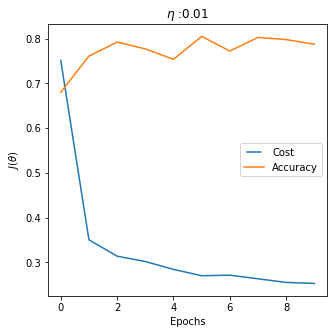

In [4]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['SepalLengthCm', 'SepalWidthCm', 
         'PetalLengthCm', 'PetalWidthCm', 
         'Species']

df = pd.read_csv(url, names=names)

# mélange des données
df=df.sample(frac=1).reset_index(drop=True)

array = df.values #necessité de convertir le dataframe en numpy
#X matrice de variables prédictives - attention forcer le type à float
X = array[:,0:4].astype('float64') 

#y vecteur de variable à prédire 
y = array[:,4]

#-----------------------------------------------------------------------------------------------------

# normalisation de X
sc_X=StandardScaler()
X=sc_X.fit_transform(X)

#-----------------------------------------------------------------------------------------------------

# Conversion de la variable à prédire via OneHotEncoder 
# Dans IRIS il y a 3 classes -> création de 3 colonnes pour y
# 1 colonne correspond à 1 classe -> 1 si la ligne est du type de la classe
# 0 sinon

# Integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

#-----------------------------------------------------------------------------------------------------

# Jeu de test/apprentissage
validation_size=0.6 #40% du jeu de données pour le test

testsize= 1-validation_size
seed=30
# séparation jeu d'apprentissage et jeu de test
X_train,X_test,y_train,y_test=train_test_split(X, 
                                               y, 
                                               train_size=validation_size, 
                                               random_state=seed,
                                               test_size=testsize)


#transformation des données pour être au bon format
# X_train est de la forme : n colonnes (variables à prédire après OneHotEncoder), m lignes (examples)
# y_train est de la forme : m colonnes, n lignes (variables à prédire après OneHotEncoder)

# La transposée de X_train est de la forme : m colonnes (exemples), n lignes (nombre de variables prédictives)
X_train=np.transpose(X_train)

# y_train est forcé pour être un tableau à 1 ligne contenant m colonnes
y_train=np.transpose(y_train.reshape((y_train.shape[0], y_train.shape[1])))

# mêmes traitements pour le jeu de test
X_test=np.transpose(X_test)
y_test=np.transpose(y_test.reshape((y_test.shape[0], y_test.shape[1])))

#-----------------------------------------------------------------------------------------------------

network = NeuralNetwork()

network.addLayer(Layer(10,input=4,activation="leakyrelu"))
network.addLayer(Layer(3,activation="softmax"))

network.info()


epochs = 10
eta = 0.01
batchsize=128

#Entraînement du classifieur
layers,cost_history,accuracy_history,parameter_history=network.fit(X_train, y_train, verbose=True, epochs=epochs)


#Prédiction
y_pred=network.predict(X_test)
accuracy_test = network.accuracy(y_pred, y_test)
print("Accuracy test: %.3f"%accuracy_test)

# Affichage des historiques
plot_histories (eta,epochs,cost_history,accuracy_history)

Epoch : #1/20 - 6/6 - cost : 0.5095 - accuracy : 0.0000
Epoch : #2/20 - 6/6 - cost : 0.4584 - accuracy : 0.1667
Epoch : #3/20 - 6/6 - cost : 0.4127 - accuracy : 0.1667
Epoch : #4/20 - 6/6 - cost : 0.3719 - accuracy : 0.1667
Epoch : #5/20 - 6/6 - cost : 0.3355 - accuracy : 0.3333
Epoch : #6/20 - 6/6 - cost : 0.3032 - accuracy : 0.3333
Epoch : #7/20 - 6/6 - cost : 0.2744 - accuracy : 0.3333
Epoch : #8/20 - 6/6 - cost : 0.2490 - accuracy : 0.5000
Epoch : #9/20 - 6/6 - cost : 0.2270 - accuracy : 0.5000
Epoch : #10/20 - 6/6 - cost : 0.2077 - accuracy : 0.5000
Epoch : #11/20 - 6/6 - cost : 0.1909 - accuracy : 0.6667
Epoch : #12/20 - 6/6 - cost : 0.1766 - accuracy : 0.8333
Epoch : #13/20 - 6/6 - cost : 0.1645 - accuracy : 0.8333
Epoch : #14/20 - 6/6 - cost : 0.1544 - accuracy : 0.8333
Epoch : #15/20 - 6/6 - cost : 0.1458 - accuracy : 0.8333
Epoch : #16/20 - 6/6 - cost : 0.1385 - accuracy : 0.8333
Epoch : #17/20 - 6/6 - cost : 0.1321 - accuracy : 1.0000
Epoch : #18/20 - 6/6 - cost : 0.1263 - a

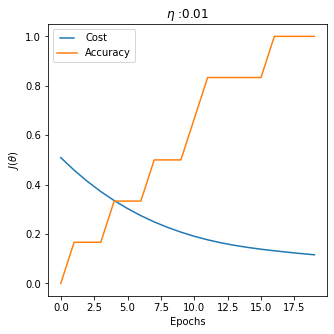

In [5]:
names = ['0','1','2','3','4','5','6','7','8','9','pred']

df = pd.read_csv('csv/mnist.csv', names=names)

# mélange des données
df=df.sample(frac=1).reset_index(drop=True)

array = df.values #necessité de convertir le dataframe en numpy
#X matrice de variables prédictives - attention forcer le type à float
X = array[:,0:10].astype('float64') 
#print(X)

#y vecteur de variable à prédire 
y = array[:,10]
#print(y)

#-----------------------------------------------------------------------------------------------------

# normalisation de X
sc_X=StandardScaler()
X=sc_X.fit_transform(X)

#-----------------------------------------------------------------------------------------------------

# Conversion de la variable à prédire via OneHotEncoder 
# Dans IRIS il y a 3 classes -> création de 3 colonnes pour y
# 1 colonne correspond à 1 classe -> 1 si la ligne est du type de la classe
# 0 sinon

# Integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

#-----------------------------------------------------------------------------------------------------

# Jeu de test/apprentissage
validation_size=0.6 #40% du jeu de données pour le test

testsize= 1-validation_size
seed=30
# séparation jeu d'apprentissage et jeu de test
X_train,X_test,y_train,y_test=train_test_split(X, 
                                               y, 
                                               train_size=validation_size, 
                                               random_state=seed,
                                               test_size=testsize)


#transformation des données pour être au bon format
# X_train est de la forme : n colonnes (variables à prédire après OneHotEncoder), m lignes (examples)
# y_train est de la forme : m colonnes, n lignes (variables à prédire après OneHotEncoder)

# La transposée de X_train est de la forme : m colonnes (exemples), n lignes (nombre de variables prédictives)
X_train=np.transpose(X_train)

# y_train est forcé pour être un tableau à 1 ligne contenant m colonnes
y_train=np.transpose(y_train.reshape((y_train.shape[0], y_train.shape[1])))

# mêmes traitements pour le jeu de test
X_test=np.transpose(X_test)
y_test=np.transpose(y_test.reshape((y_test.shape[0], y_test.shape[1])))

#-----------------------------------------------------------------------------------------------------

network = NeuralNetwork()

network.addLayer(Layer(20,input=10,activation="leakyrelu"))
network.addLayer(Layer(10,activation="softmax"))

#network.info()

epochs = 20
eta = 0.01
batchsize=128

#Entraînement du classifieur
layers,cost_history,accuracy_history,parameter_history=network.fit(X_train, y_train, verbose=True, epochs=epochs)


#Prédiction
y_pred=network.predict(X_test)
accuracy_test = network.accuracy(y_pred, y_test)
print("Accuracy test: %.3f"%accuracy_test)

# Affichage des historiques
plot_histories (eta,epochs,cost_history,accuracy_history)